In [ ]:
!python3 ../preprocess/Main.py

# Import All Libreries

In [1]:
import matplotlib.pyplot as plt
from PIL import Image       
import numpy as np

# Import & Reload FunctionsFile.py

In [2]:
from importlib import reload
import FunctionsFile as f
reload(f)

<module 'FunctionsFile' from '/Users/book/Downloads/Learning/DataScienceWithPython/PFE/src/FunctionsFile.py'>

# Extract Data from .txt files

In [3]:
from FunctionsFile import *

train_img_paths,train_CleanedLabels,test_img_paths,test_CleanedLabels,validation_img_paths,validation_CleanedLabels,characters,length = ExtractData(
    'train_img_paths','train_CleanedLabels',
    'test_img_paths','test_CleanedLabels',
    'validation_img_paths','validation_CleanedLabels',
    'characters','max_len')
    

In [4]:
max_len = int(length[0])

print(f'''
Train Images : {len(train_img_paths)}
Train Labels : {len(train_CleanedLabels)}
Test Images : {len(test_img_paths)}
Test Labels: {len(test_CleanedLabels)}
Validation Images : {len(validation_img_paths)}
Validation Labels : {len(validation_CleanedLabels)}
Number of unique Characters  : {len(characters)} 
Length of Largest Word : {max_len}
''')


Train Images : 86808
Train Labels : 86808
Test Images : 4823
Test Labels: 4823
Validation Images : 4823
Validation Labels : 4823
Number of unique Characters  : 79 
Length of Largest Word : 21



# Some images with their labels with different sizes

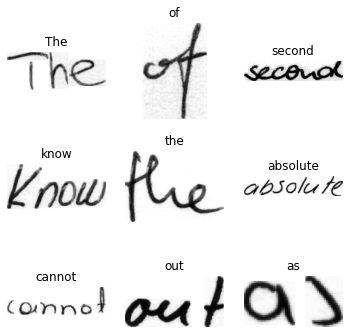

In [5]:
plt.figure(figsize=(6,6))

for i in range(9) : 
    img = Image.open(test_img_paths[i])
    plt.subplot(3,3,i+1)
    plt.axis('off') 
    plt.title(test_CleanedLabels[i])
    #img = img.resize((128,32))
    plt.imshow(img,cmap='gray')

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


2022-06-12 10:08:16.945048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Resize images (width = 128, height = 32)

In [41]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = resizeImages(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)
    


In [42]:
train_ds = prepare_dataset(train_img_paths, train_CleanedLabels)
validation_ds = prepare_dataset(validation_img_paths, validation_CleanedLabels)
test_ds = prepare_dataset(test_img_paths, test_CleanedLabels)

2022-06-12 12:07:06.472680: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


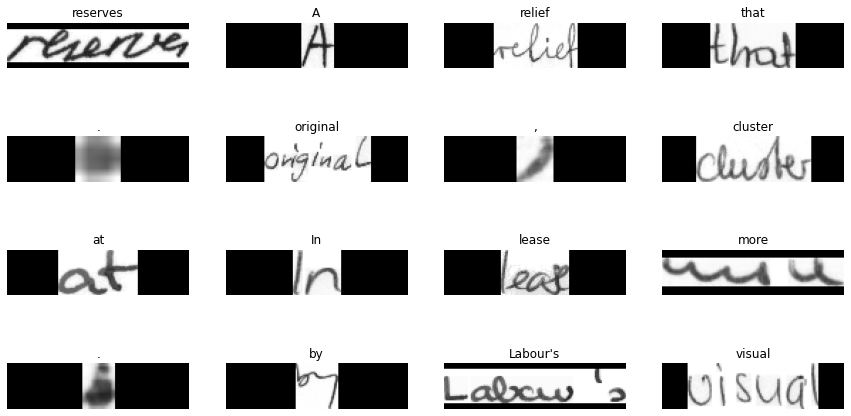

In [43]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


In [44]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [53]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv-1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="MaxPool-1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv-2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="MaxPool-2")(x)

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="Dense-1")(x)
    x = keras.layers.Dropout(0.2,name="Dropout")(x)

    # RNNs.
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25, name="Blstm-1"))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25, name="Blstm-2"))(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="Dense-2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="CTC")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="HTR"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt,)
    return model


In [54]:
model = build_model()
model.summary()


Model: "HTR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv-1 (Conv2D)                (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 MaxPool-1 (MaxPooling2D)       (None, 64, 16, 32)   0           ['Conv-1[0][0]']                 
                                                                                                  
 Conv-2 (Conv2D)                (None, 64, 16, 64)   18496       ['MaxPool-1[0][0]']            

In [ ]:
epochs = 50 

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="Image").input, model.get_layer(name="Dense-2").output
)
# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
)


In [55]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



In [75]:
model = build_model()

checkpoint_path = "training_1/cp.ckpt"
model.load_weights(checkpoint_path)

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="Dense-2").output
)


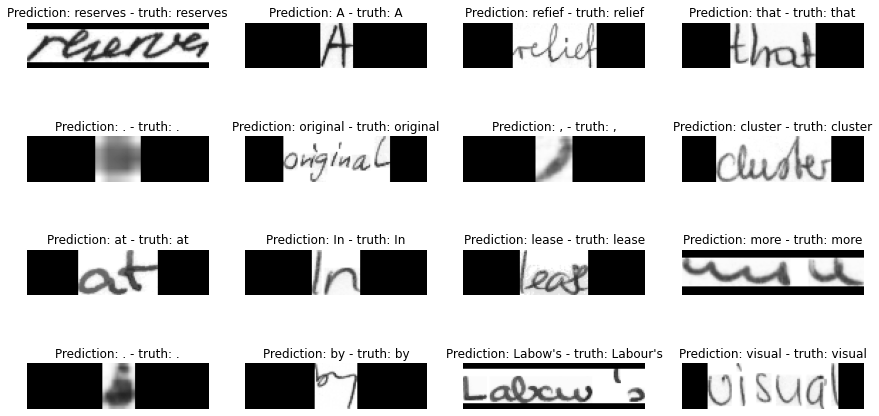

In [76]:

#  check results on some test samples.
for batch in test_ds.take(1):
    batch_images, batch_labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        title = f"Prediction: {pred_texts[i]} | truth: {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [92]:
corr = 0
incorr = 0
for batch in test_ds.take(10):
    batch_images, batch_labels = data["image"], data["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    corr+=1
print(corr)
    
''' for i in range(len(preds)):
    
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    
    if pred_texts[i] == label : 
        corr+=1
    else : 
        incorr += 1
        print(f"Prediction: {pred_texts[i]}         truth : {label}")
    print(corr,incorr)       '''


10


' for i in range(len(preds)):\n    \n    label = labels[i]\n    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))\n    label = tf.strings.reduce_join(num_to_char(indices))\n    label = label.numpy().decode("utf-8")\n    \n    if pred_texts[i] == label : \n        corr+=1\n    else : \n        incorr += 1\n        print(f"Prediction: {pred_texts[i]}         truth : {label}")\n    print(corr,incorr)       '

In [57]:
test = prepare_dataset(["words/1.png","words/2.png","words/3.png","words/4.png","words/5.png","words/6.png"], ["moha","Head","Algeria","body","Test","water"])

6


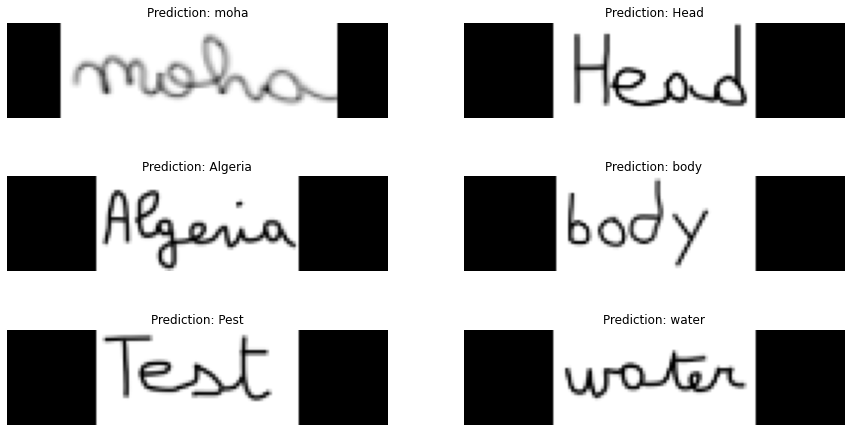

In [91]:
#  Let's check results on some test samples.
for batch in test:
    batch_images = batch["image"]
    _, ax = plt.subplots(3, 2, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(len(preds))
    for i in range(6):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(title)
        ax[i // 2, i % 2].axis("off")

plt.show()